# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv("/datasets/taxi.csv", parse_dates=['datetime'], index_col='datetime')

In [3]:
df.sort_index(inplace=True)

In [4]:
data = df.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
df.query("num_orders > 90")

,num_orders
datetime,
2018-08-13 02:20:00,119
2018-08-13 02:30:00,99
2018-08-20 02:20:00,94
2018-08-20 04:00:00,91
2018-08-27 02:00:00,98
2018-08-27 02:10:00,119
2018-08-30 17:50:00,95


In [8]:
print(df.index.is_monotonic)

True


#### Данные предварительно обработаны, индексом заданы даты, проверена монотонность индексов. Пропуски и аномалии отсутствуют.

In [9]:
df = df.resample('1D').sum()

#### Семплируем данные по часу, т.к. дальнейшее предсказание требуется делать на последующий час.

# 2. Анализ

In [10]:
decomposed = seasonal_decompose(df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

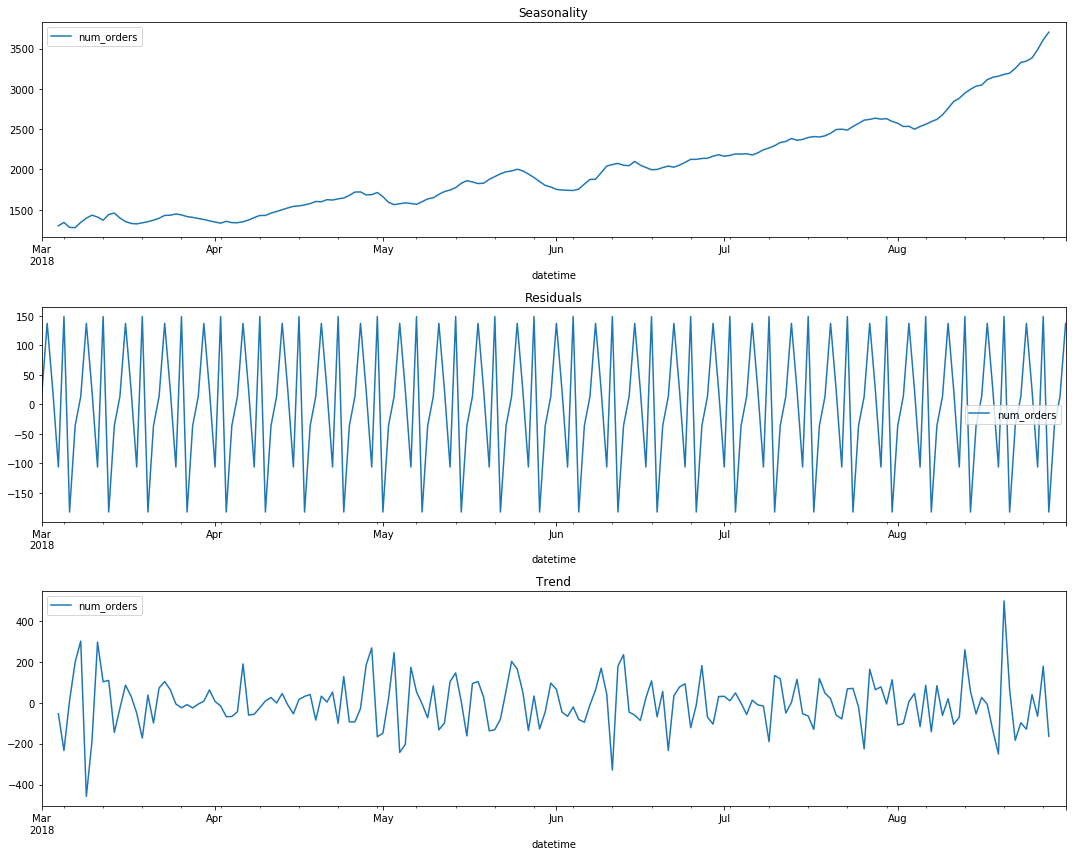

In [11]:
plt.figure(figsize=(15, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Trend')
plt.subplot(311)
plt.title('Seasonality')
plt.subplot(312)
plt.title('Residuals')
plt.subplot(313)

plt.tight_layout()

#### о сезонности говорить сложно, т.к. нам предоставлены данные лишь за пол 2018 года, однако просматривается явная тенденция к увеличению количества заказов к окончанию периода.  
#### В тренде же под самый конец рассматриваемого периода наблюдается почти незаметный подъем среднего заказов такси.

In [12]:
df['rolling'] = df['num_orders'].rolling(25).mean()
df['std'] = df['num_orders'].rolling(25).std()

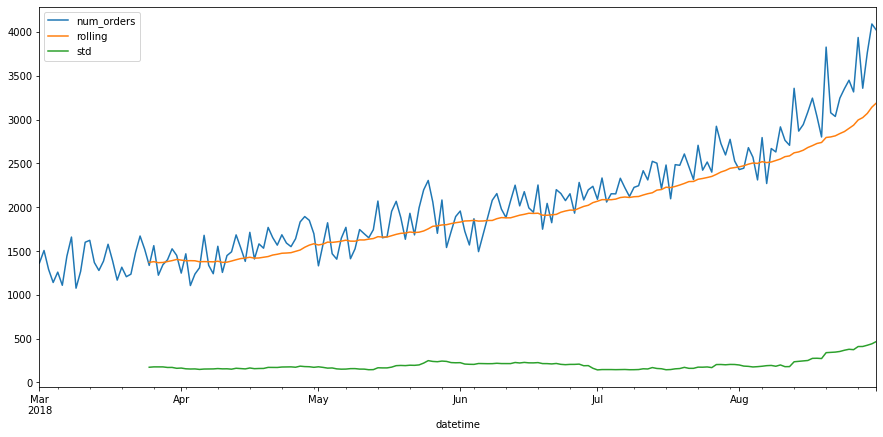

In [13]:
df.plot(figsize=(15, 7))

In [14]:
df = df - df.shift()
df['rolling'] = df['num_orders'].rolling(25).mean()
df['std'] = df['num_orders'].rolling(25).std()

#### Посмотрев на скользящее среднее и стандартное отклонение видим медленный подъем среднего количества заказов такси на всем протяжении полугодия.

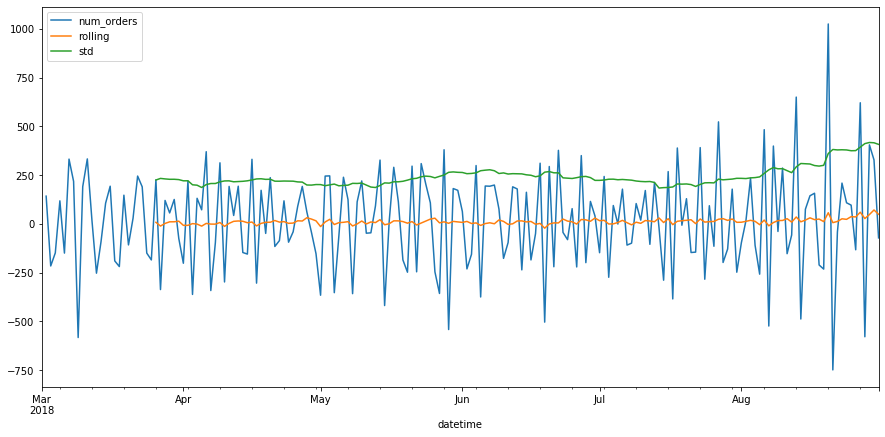

In [15]:
df.plot(figsize=(15, 7))

#### Приведя график к более стационарному виду, видим что стандартное отклонение так же увеличивается к концу периода.

# 3. Обучение

#### Подготовим признаки для обучения моделей.

In [16]:
data = data.resample('1H').sum()

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [18]:
make_features(data, 4, 25)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,165.36
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,163.72
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,167.00


In [19]:
train, test = train_test_split (data, test_size=0.1, shuffle = False)

In [20]:
train, valid = train_test_split (train, test_size=0.1, shuffle = False)

In [21]:
train.dropna(inplace=True)

In [22]:
display(train.shape)
display(valid.shape)
display(test.shape)

(3551, 10)

(398, 10)

(442, 10)

In [23]:
X_train = train.drop("num_orders", axis=1)
y_train = train['num_orders']
X_valid = valid.drop("num_orders", axis=1)
y_valid = valid['num_orders']
X_test = test.drop("num_orders", axis=1)
y_test = test['num_orders']

### LinearRegression

In [24]:
linear = LinearRegression ()

In [25]:
linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
pred_train = linear.predict (X_train)
pred_valid = linear.predict (X_valid)
pred_test = linear.predict (X_test)

In [27]:
print("RMSE на обучающей выборке:", mean_squared_error (y_train, pred_train)**0.5)
print("RMSE на валидационной выборке:", mean_squared_error (y_valid, pred_valid)**0.5)
print("RMSE на тестовой выборке:", mean_squared_error (y_test, pred_test)**0.5)

RMSE на обучающей выборке: 29.12656783458981
RMSE на валидационной выборке: 40.64118364197966
RMSE на тестовой выборке: 51.31356408672544


### CatBoost

In [ ]:
param = {'iterations':(300, 400, 500, 700, 900),
        'learning_rate':(0.1, 0.2, 0.3, 0.4,  0.5),
        'bootstrap_type':['Bayesian', 'Bernoulli', 'MVS']
        }

In [ ]:

catboost = RandomizedSearchCV (CatBoostRegressor (), 
                               param_distributions = param, 
                               n_iter=100, 
                               cv=3, 
                               n_jobs=-1, 
                               random_state=42,
                              verbose=1)

In [ ]:
%%time
catboost.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=250, use_best_model=True, early_stopping_rounds=50)

In [ ]:
catboost.best_params_

In [28]:
catboost = CatBoostRegressor (random_state=42)

In [29]:
%%time
catboost.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=250, use_best_model=True, early_stopping_rounds=50)

0:	learn: 35.4912020	test: 57.7847456	best: 57.7847456 (0)	total: 49.2ms	remaining: 49.2s
250:	learn: 19.6878206	test: 33.2258850	best: 33.2139813 (248)	total: 4.78s	remaining: 14.3s
500:	learn: 17.4419137	test: 32.1748536	best: 32.1627378 (498)	total: 9.88s	remaining: 9.84s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 32.07155547
bestIteration = 563

Shrink model to first 564 iterations.
CPU times: user 10.9 s, sys: 1.68 s, total: 12.6 s
Wall time: 17.2 s


In [53]:
pred_train = catboost.predict (X_train)
pred_valid = catboost.predict (X_valid)
pred_test = catboost.predict (X_test)

In [54]:
print("RMSE на обучающей выборке:", mean_squared_error (y_train, pred_train)**0.5)
print("RMSE на валидационной выборке:", mean_squared_error (y_valid, pred_valid)**0.5)
print("RMSE на тестовой выборке:", mean_squared_error (y_test, pred_test)**0.5)

RMSE на обучающей выборке: 16.998614012838562
RMSE на валидационной выборке: 32.07155546740992
RMSE на тестовой выборке: 54.67527267302764


### XGBoost

In [ ]:
param = {'max_depth':(1, 5, 10, 15, 20),
        'learning_rate':(0.1, 0.2, 0.3, 0.4, 0.5),
        'n_estimators':(50, 100, 150, 200),
        'booster':['gbtree', 'gblinear', 'dart']
        }

In [ ]:
xgb = RandomizedSearchCV (XGBRegressor(), 
                               param_distributions = param, 
                               n_iter=100, 
                               cv=3, 
                               n_jobs=-1, 
                               random_state=42,
                              verbose=1)

In [ ]:
%%time
xgb.fit(X_train, y_train)

In [ ]:
xgb.best_params_

In [55]:
xgb = XGBRegressor (random_state=42)

In [56]:
%%time
xgb.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 230 ms, sys: 0 ns, total: 230 ms
Wall time: 239 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [57]:
pred_train = xgb.predict (X_train)
pred_valid = xgb.predict (X_valid)
pred_test = xgb.predict (X_test)

In [58]:
print("RMSE на обучающей выборке:", mean_squared_error (y_train, pred_train)**0.5)
print("RMSE на валидационной выборке:", mean_squared_error (y_valid, pred_valid)**0.5)
print("RMSE на тестовой выборке:", mean_squared_error (y_test, pred_test)**0.5)

RMSE на обучающей выборке: 19.463803767909358
RMSE на валидационной выборке: 31.914978877347878
RMSE на тестовой выборке: 46.88136540941003


### LightGBM

In [ ]:
param = {'max_depth':(1, 5, 10, 15, 20, 25, 30),
        'learning_rate':(0.1, 0.2, 0.3, 0.4, 0.5),
        'n_estimators':(50, 100, 150, 200, 250),
        'boosting_type':['gbdt', 'dart', 'goss']}

In [ ]:
lgbm = RandomizedSearchCV (LGBMRegressor(), 
                               param_distributions = param, 
                               n_iter=100, 
                               cv=3, 
                               n_jobs=-1, 
                               random_state=42,
                               verbose=1)

In [ ]:
%%time
lgbm.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)

In [ ]:
lgbm.best_params_

In [59]:
lgbm = LGBMRegressor (random_state=42)

In [60]:
%%time
lgbm.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)

CPU times: user 162 ms, sys: 0 ns, total: 162 ms
Wall time: 164 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [61]:
pred_train = lgbm.predict (X_train)
pred_valid = lgbm.predict (X_valid)
pred_test = lgbm.predict (X_test)

In [62]:
print("RMSE на обучающей выборке:", mean_squared_error (y_train, pred_train)**0.5)
print("RMSE на валидационной выборке:", mean_squared_error (y_valid, pred_valid)**0.5)
print("RMSE на тестовой выборке:", mean_squared_error (y_test, pred_test)**0.5)

RMSE на обучающей выборке: 13.911887501196508
RMSE на валидационной выборке: 31.65882348043839
RMSE на тестовой выборке: 52.37373269491289


# 4. Тестирование

### Для тестирования адекватности моделей применим DummyRegressor

In [46]:
dummy = DummyRegressor (strategy='median')

In [47]:
dummy.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='median')

In [48]:
pred_train = dummy.predict (X_train)
pred_valid = dummy.predict (X_valid)
pred_test = dummy.predict (X_test)

In [49]:
print("RMSE на обучающей выборке:", mean_squared_error (y_train, pred_train)**0.5)
print("RMSE на валидационной выборке:", mean_squared_error (y_valid, pred_valid)**0.5)
print("RMSE на тестовой выборке:", mean_squared_error (y_test, pred_test)**0.5)

RMSE на обучающей выборке: 36.053708488919675
RMSE на валидационной выборке: 59.533361281953816
RMSE на тестовой выборке: 88.64441651443998


## ВЫВОД:
- В данной работе требовалось подготовить наилучшую модель для предсказания временных рядов в «Чётеньком такси» на следующий час, для определения количества привлекаемых водителей.
- После знакомства с данными и приведением их в удобный для работы вид, в ходе анализа была изучена сезонность данных, а так же их тренд на предлагаемый период времени. Так же в ходе анализа, опытным путем, было определено окно для скользящего среднего, проведен фичеинженеринг.
- Для предсказания были выбраны следующие регрессоры: Линейный, CatBoost, XGBoost, LightGBM. Все регрессоры, за исключением линейного показали хороший результат и обозначеный порог RMSE был с легкостью преодален. Адекватность моделей подтверждена сравнением их предсказаний с Dummy регрессором, предсказывающим по стратегии медианы.
- В качестве основной модели предлагаю использовать XGBoost, точность предсказаний которого соответствует условию, а скорость обучения остается на приемлимом уровне.